In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning

from jas1101finalproject.fit import sigmar_2
from jas1101finalproject.fit import set_prior, set_likelihood
from jas1101finalproject.fit import DynamicNestedSampler

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

### Read GC

In [2]:
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_name(gc_name)
GC.table_full[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm,member_prob_GMM,member_prob_DB
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
-0.1977684,-0.5888955,4.437221,-3.046831,2.568937,2.304999,-0.4350196,20.7788,0.816515,0,0.0,0.621216749580056,5.382574601935583,0.0,0.0
-0.1322767,-0.5762618,-0.06046668,-1.399454,1.140334,1.009628,-0.3081436,20.19374,0.8388195,0,0.0,0.5912484989428134,1.4007596929902795,0.0,0.0
-0.1302095,-0.5841963,25.03454,2.431298,1.950605,1.598516,-0.1853718,20.80205,2.071041,0,0.0,0.5985313950194593,25.152324007463086,0.0,0.0
-0.1348291,-0.4223898,4.965001,-1.958991,0.4321207,0.2950536,-0.2759779,18.64288,0.9655228,1,0.9608296,0.4433869972730932,5.337497603566862,1.0,0.0
-0.1274993,-0.6036617,0.6542604,-0.6097682,0.1797256,0.1373819,-0.1256039,17.40447,1.302572,1,0.0,0.6169793509894638,0.8943567122459584,0.0,0.0
-0.1955425,-0.5675544,5.504682,-9.945943,0.7583949,0.6022504,-0.2220912,19.82244,0.9101028,1,0.0,0.6002956490477088,11.36764294303674,0.0,0.0
-0.1460269,-0.5634596,4.810706,-2.849002,0.4770243,0.3784877,-0.1997244,19.0192,0.9610672,1,0.9145111,0.5820743735604326,5.591037883473872,0.0,0.0
-0.2434435,-0.5949736,0.4228585,-1.417316,0.3190453,0.2436593,-0.2938729,18.47891,1.179855,1,0.0,0.6428517110416756,1.4790517079798968,0.0,0.0


In [3]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.015,5.8134967962492246,"1.3768803520135557,0.14529010919422547,-4.281715927103217"


### Make a new GC table using HDBSCAN membership

In [4]:
dmls: u.Quantity = u.dimensionless_unscaled  # shortcut

tab_DB = GC.table_full[GC.table_full['member_prob_DB']==1]
tab_DB['pm_e'] = np.hypot(tab_DB['pmx_e'], tab_DB['pmx_e'])

GC_DB = pd.DataFrame({'r':(tab_DB["r"] / GC.rc_ang).to_value(dmls),
                      'pm':(tab_DB["pm"] / GC.pmc_ang).to_value(dmls),
                      'pm_e':(tab_DB["pm_e"] / GC.pmc_ang).to_value(dmls)})

### Distibution of PM-R with Eugene's GMM membership

In [5]:
good = GC.pm_e < 2
good_DB = GC_DB.pm_e < 2

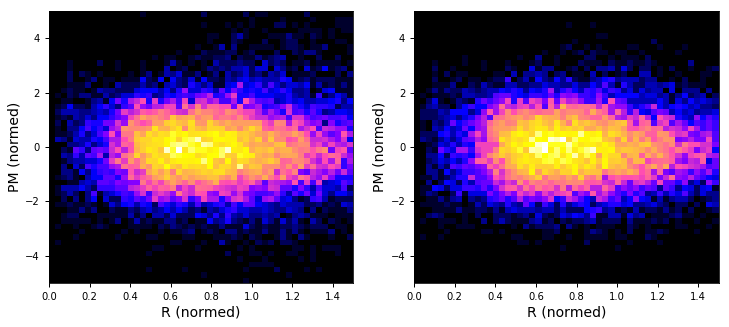

In [6]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

H, xb, yb, _ = ax1.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")
H, xb, yb, _ = ax2.hist2d(GC.r[good], GC.pm[good]-GC.pm[good].mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

### Distibution of PM-R with HDBSCAN membership

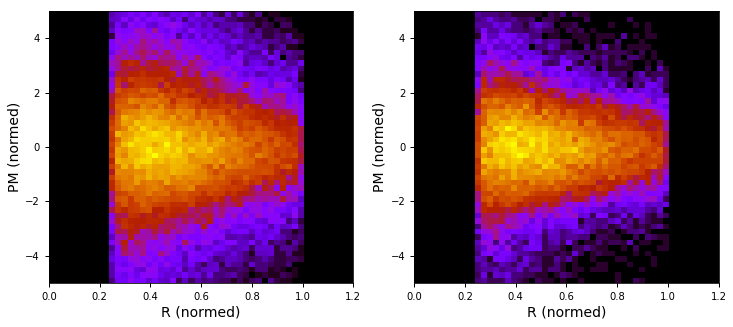

In [7]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

H, xb, yb, _ = ax1.hist2d(GC_DB.r, GC_DB.pm-GC_DB.pm.mean(), bins=50, range=[[0,1.2],[-5,5]], norm=AsinhNorm(), cmap="gnuplot")
H, xb, yb, _ = ax2.hist2d(GC_DB.r[good_DB], GC_DB.pm[good_DB]-GC_DB.pm[good_DB].mean(), bins=50, range=[[0,1.2],[-5,5]], norm=AsinhNorm(), cmap="gnuplot")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

### Draw comparison of binned sigma profiles 
#### 1) with Eugene's GMM membership
#### 2) HDBSCAN membership
#### 3) without memeber selection.

In [8]:
# parameter of GC
M_gc = 1e6
r_scale = 24

good = GC.pm_e < 2
good_DB = GC_DB.pm_e < 2

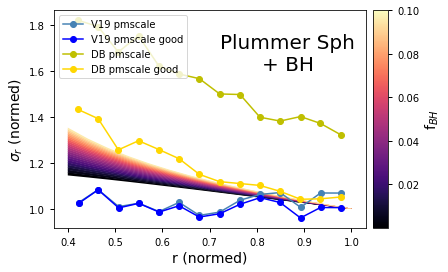

In [9]:
r_min, r_max = 0.4, 1
bins = np.linspace(r_min, r_max, 15)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.1, N_mod=25, fig=fig)

### Distribution in Radius

(0, 1.2)

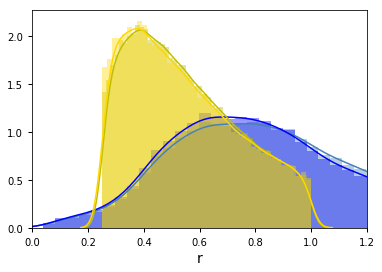

In [10]:
sns.distplot(GC.r, color='steelblue')
sns.distplot(GC.r[good], color='blue')
sns.distplot(GC_DB.r, color='y')
sns.distplot(GC_DB.r[good_DB], color='gold')
# plt.axvspan(r_min, r_max, color='k', alpha=0.2)
plt.xlim(0,1.2)

0.5222853363104658 0.9282815052919147


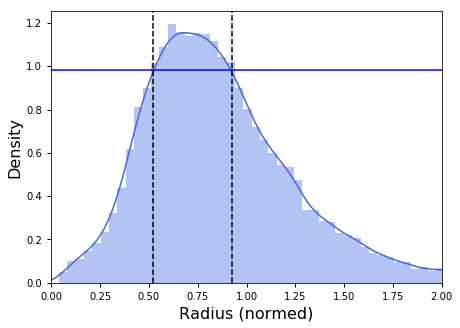

In [31]:
plt.figure(figsize=(7,5))
p = sns.distplot(GC.r[good], color='royalblue')
x_kde, y_kde = p.get_lines()[0].get_data()

x_peak = x_kde[np.argmax(y_kde)]
y_sol = y_kde.max()*0.85
left, right = x_kde<x_peak, x_kde>x_peak
x_left, x_right = [x_kde[side][np.argmin(abs(y_kde-y_sol)[side])] for side in (left, right)]
print(x_left, x_right)

plt.axhline(y_sol, color='blue', ls='-')
plt.xlim(0,2)
plt.xlabel('Radius (normed)', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.axvline(x_left, color='k',ls='--')
plt.axvline(x_right, color='k',ls='--')

r_min, r_max = x_left, x_right
plt.savefig('../../pic/Tuc_47_radius.pdf')

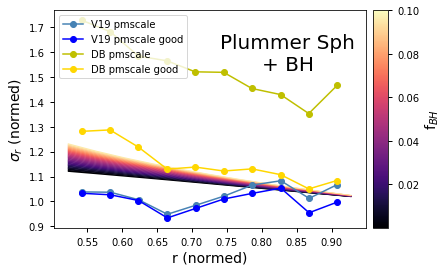

In [23]:
bins = np.linspace(r_min, r_max, 11)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.1, N_mod=25, fig=fig)

## Fitting sigma profile of a single cluster

In [24]:
#r_min, r_max = 0.1, 1.5

use_DB = False
if use_DB:
    r, pm, pm_e = GC_DB.r, GC_DB.pm, GC_DB.pm_e
else:
    r, pm, pm_e = GC.r, GC.pm, GC.pm_e

# conditional cut
cond = (r>=r_min) & (r<=r_max) & (pm_e < 2)

# x and y, y_err for fitting
pm, pm_e = pm[cond], pm_e[cond]
r = r[cond]

PM = 14.636 +/- 1.008 


Text(0.5, 0, 'PM')

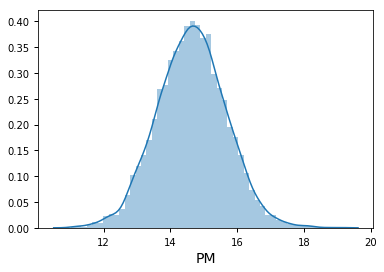

In [25]:
sns.distplot(pm)
print("PM = %.3f +/- %.3f "%(np.mean(pm), mad_std(pm)))
plt.xlabel("PM")

### Setup prior and likelihood

In [26]:
kind = 'scale-outlier'
prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=25, mu_ol_max=25)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

### Run Fitting

In [28]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=600, maxbatch=10)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 6


iter: 10379 | batch: 0 | bound: 40 | nc: 1 | ncall: 56987 | eff(%): 18.213 | loglstar:   -inf < -13984.171 <    inf | logz: -14000.103 +/-  0.280 | dlogz:  0.001 >  0.609                            



Finish Fitting! Total time elapsed: 414 s

Pool Closed.


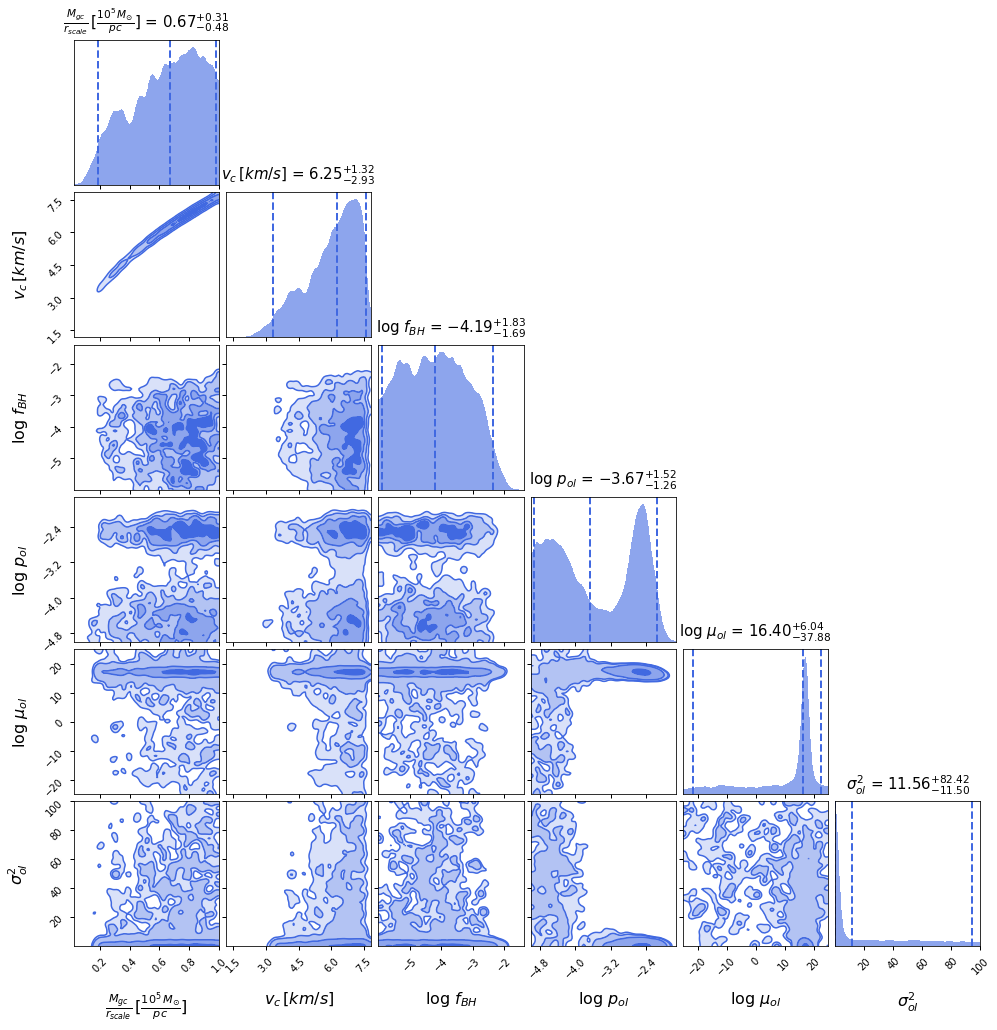

In [29]:
# Plot result joint and marginal PDF
labels = [r'$\frac{M_{gc}}{r_{scale}}\,[\frac{10^5\,M_{\odot}}{pc}]$',
          '$v_{c}\,[km/s]$', r'log $f_{BH}$',
          r'log $p_{ol}$', r'log $\mu_{ol}$', r'$\sigma^2_{ol}$']
dsampler.cornerplot(figsize=(14,14), labels=labels, title_kwargs={'fontsize':15, 'y': 1.04})
# plt.savefig('/home/qliu/Desktop/astrostats/jas1101/pic/Tuc47_DB.png',dpi=200)

In [30]:
10**(-4.19+1.83)

0.004365158322401657

## Visualizing Fitting Result

## 1.  Fit in 0.4 < R < 0.7

#### DBSCAN membership

with measurement error and outlier

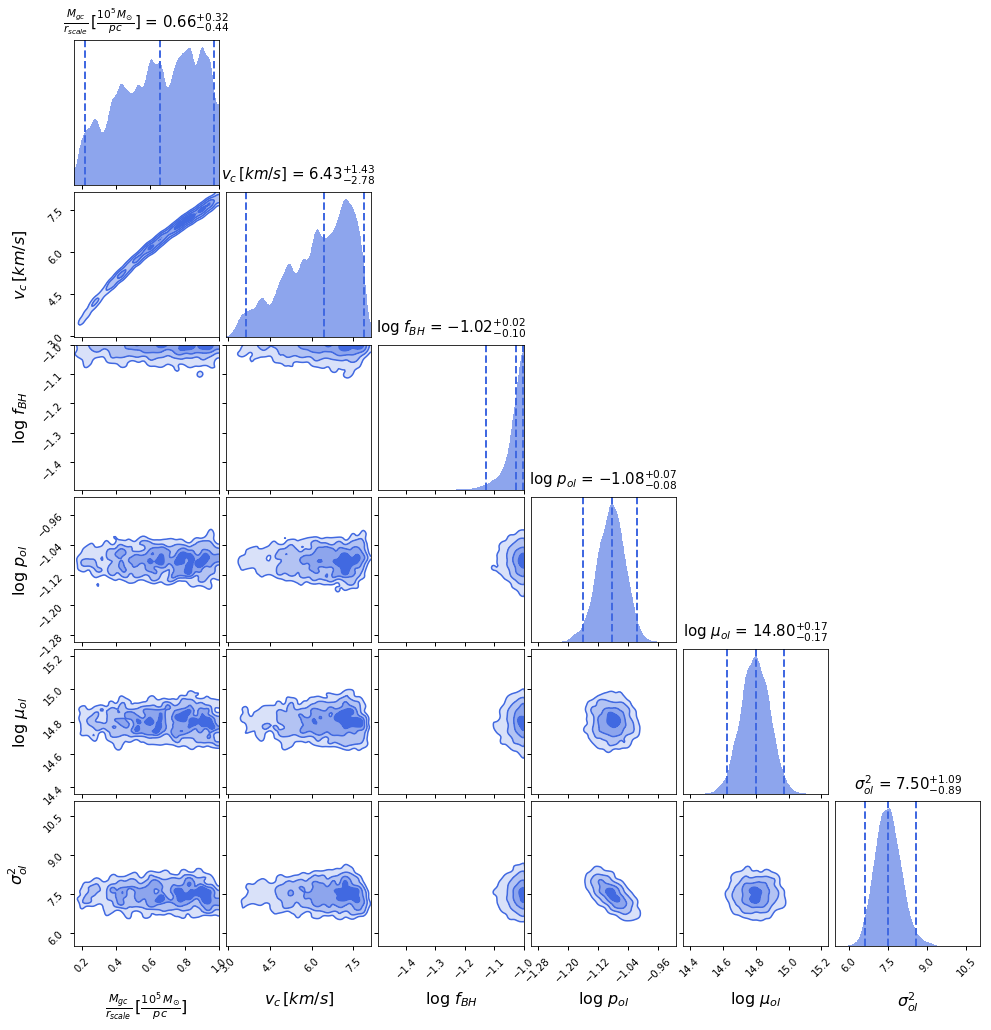

In [32]:
# Plot result joint and marginal PDF
labels = [r'$\frac{M_{gc}}{r_{scale}}\,[\frac{10^5\,M_{\odot}}{pc}]$',
          '$v_{c}\,[km/s]$', r'log $f_{BH}$',
          r'log $p_{ol}$', r'log $\mu_{ol}$', r'$\sigma^2_{ol}$']
dsampler.cornerplot(figsize=(14,14), labels=labels, title_kwargs={'fontsize':15, 'y': 1.04})
# plt.savefig('/home/qliu/Desktop/astrostats/jas1101/pic/Tuc47_DB.png',dpi=200)

#### Eugene's membership

without measurement error / outlier

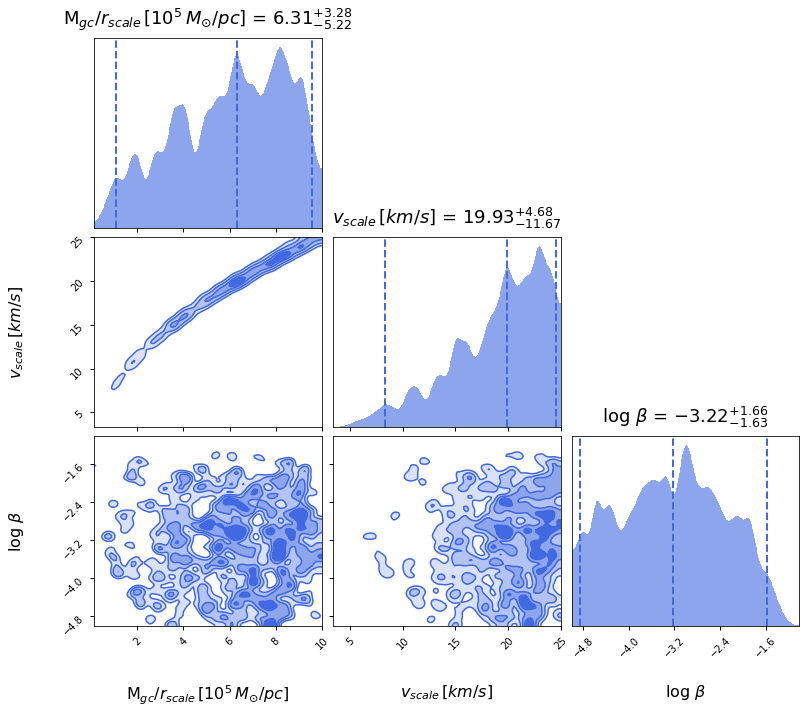

In [202]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$']
dsampler.cornerplot(labels=labels)

with measurement error and outlier

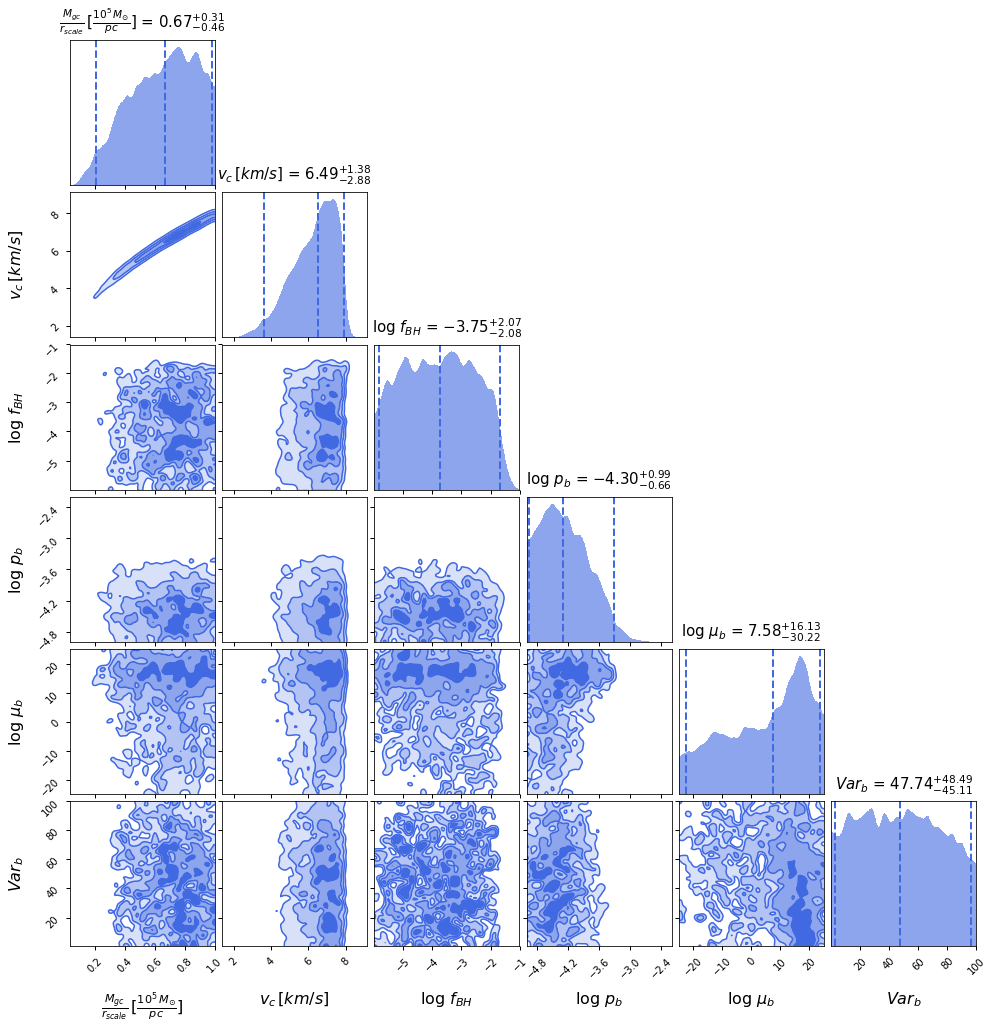

In [78]:
# Plot result joint and marginal PDF
labels = [r'$\frac{M_{gc}}{r_{scale}}\,[\frac{10^5\,M_{\odot}}{pc}]$',
          '$v_{c}\,[km/s]$', r'log $f_{BH}$',
          r'log $p_{b}$', r'log $\mu_{b}$', r'$Var_{b}$']
dsampler.cornerplot(figsize=(14,14), labels=labels, title_kwargs={'fontsize':15, 'y': 1.04})
# plt.savefig('/home/qliu/Desktop/astrostats/jas1101/pic/Tuc47_2.png',dpi=200)

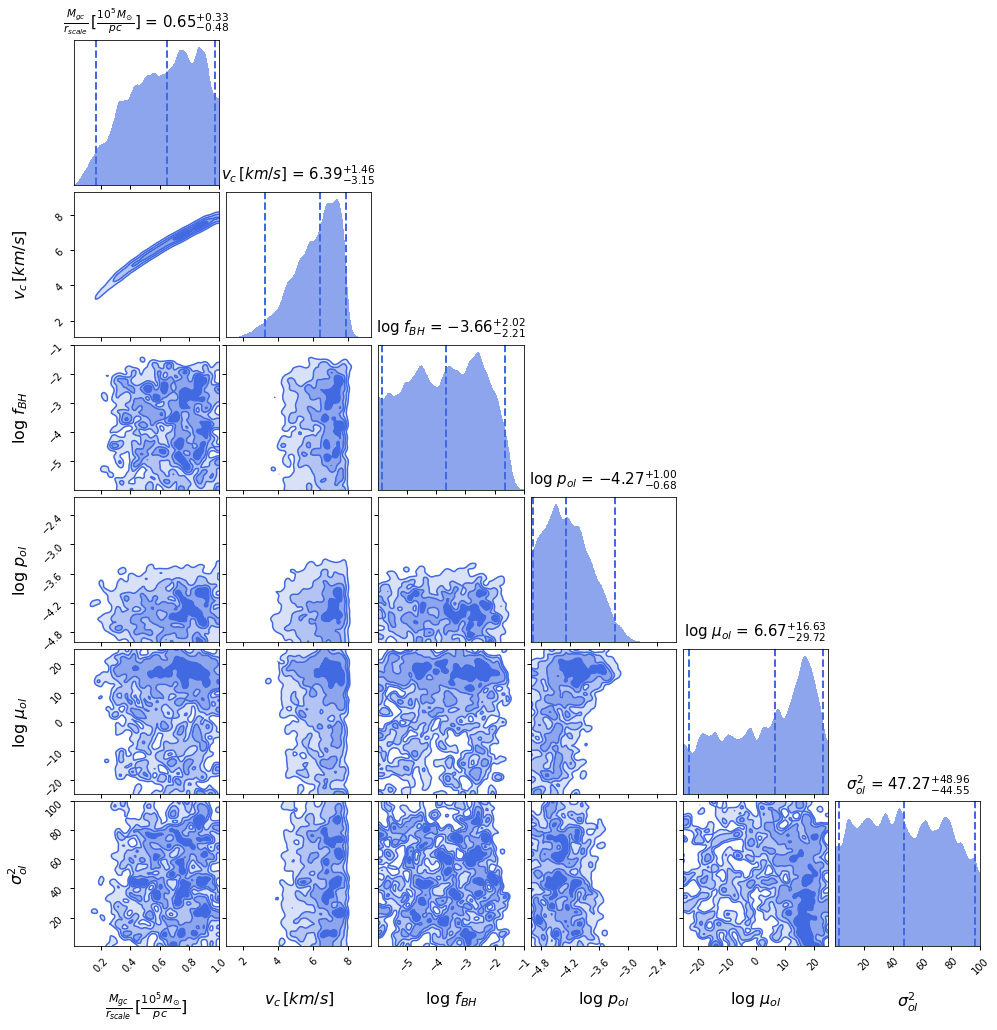

In [60]:
# Plot result joint and marginal PDF
labels = [r'$\frac{M_{gc}}{r_{scale}}\,[\frac{10^5\,M_{\odot}}{pc}]$',
          '$v_{c}\,[km/s]$', r'log $f_{BH}$',
          r'log $p_{b}$', r'log $\mu_{b}$', r'$\Var_{b}$']
dsampler.cornerplot(figsize=(14,14), labels=labels, title_kwargs={'fontsize':15, 'y': 1.04})
# plt.savefig('/home/qliu/Desktop/astrostats/jas1101/pic/Tuc47.png',dpi=200)

In [41]:
pmed, _, _, samples = dsampler.get_params(return_sample=True)

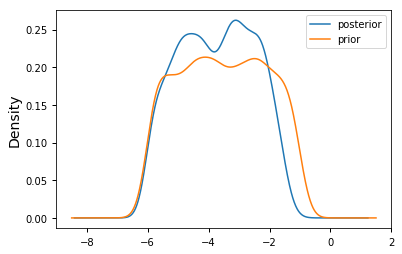

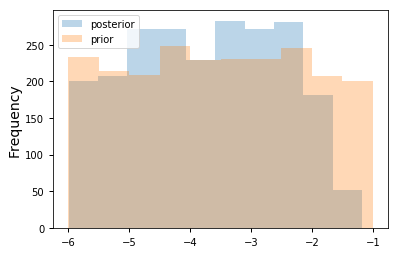

In [69]:
from jas1101finalproject.stats import Stats_output
prior = np.random.uniform(low=-6,high=-1, size=len(samples)) # generate random uniform
posterior = samples[:,2].copy()
obj = Stats_output(prior,posterior)
obj.posterior
obj.prior
obj.bootstrap(0.95)
obj.lbound
obj.ubound
obj.ubound
obj.plots()
obj.comparisons()

In [70]:
obj.KS_pval

3.475764210747943e-13

## 2. Fit in 0.4 < R < 1

#### Eugene's membership

with measurement error and outlier

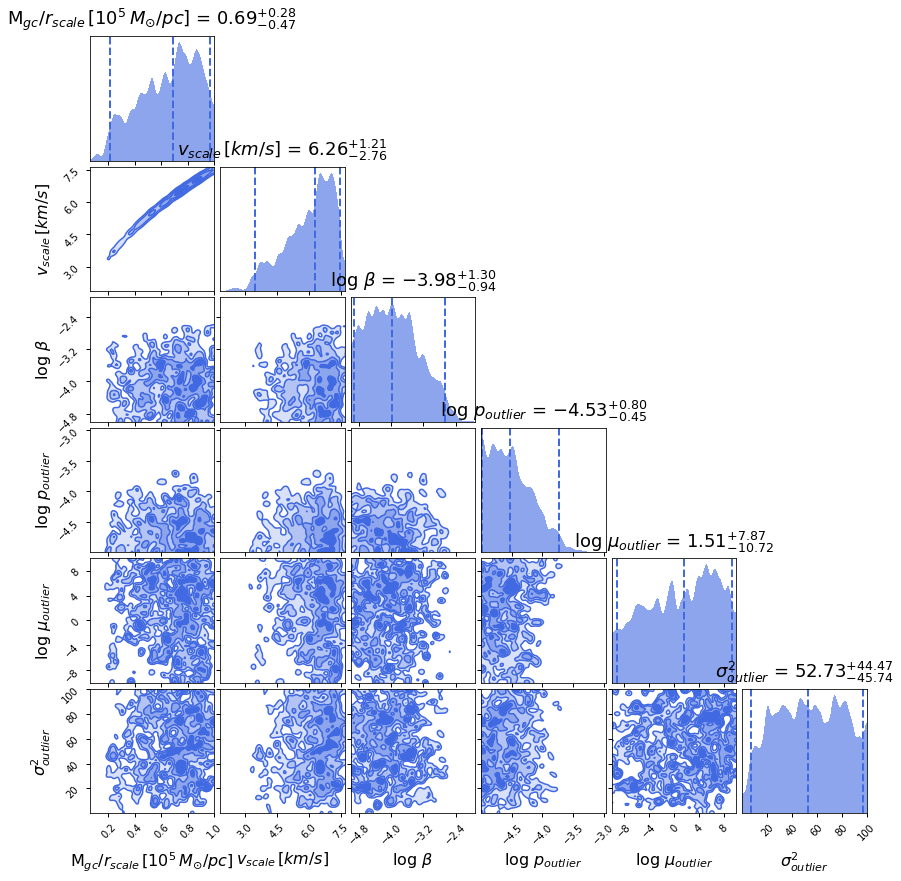

In [162]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12), labels=labels)

## 3. Fit R$_{min}$ and R$_{max}$

In [49]:
kind = 'scale-outlier-range'
prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=20, mu_ol_max=40)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

In [50]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=200, maxbatch=2)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 8


iter: 6400 | batch: 2 | bound: 68 | nc: 2 | ncall: 25745 | eff(%): 24.859 | loglstar: -3854.247 < -3851.485 < -3852.415 | logz: -3879.021 +/-  0.514 | stop:  3.207                                   



Finish Fitting! Total time elapsed: 101 s

Pool Closed.


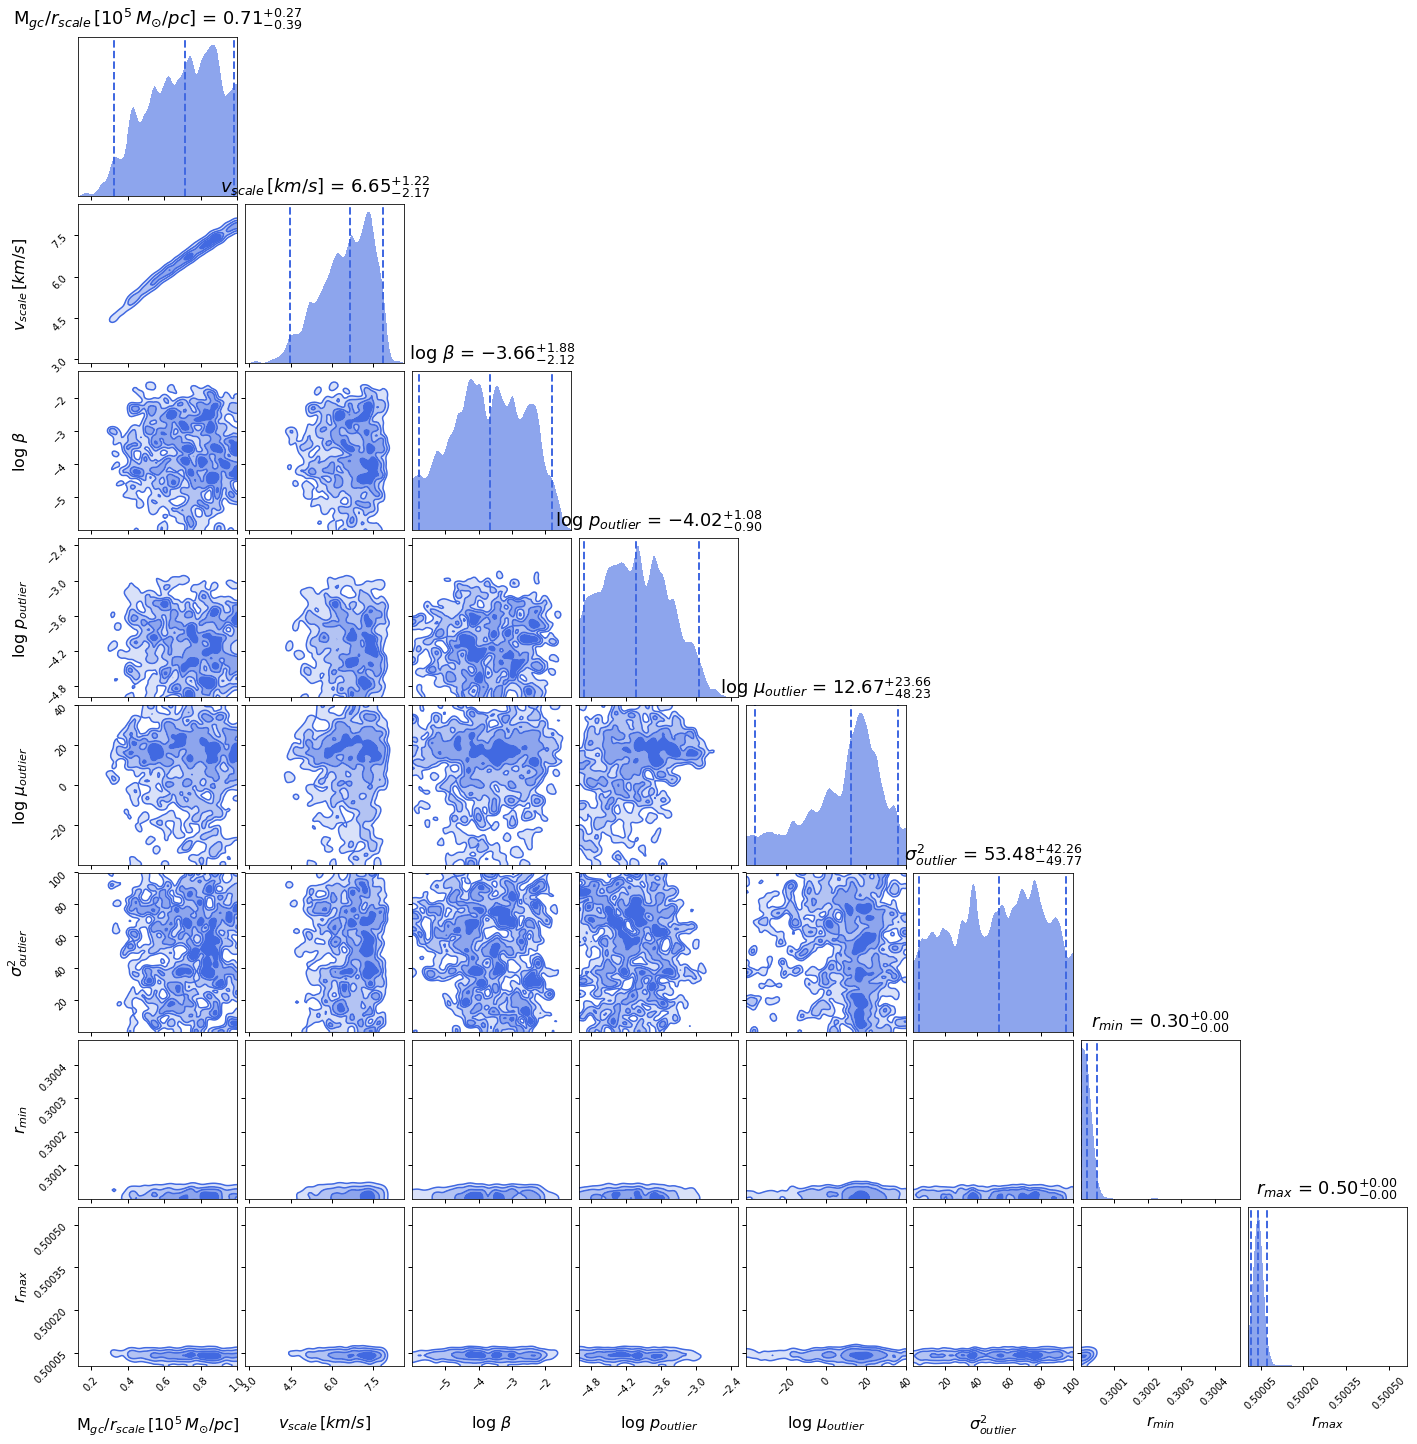

In [51]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$',
          '$r_{min}$', '$r_{max}$']
dsampler.cornerplot(figsize=(20,20), labels=labels)

Text(0.5, 0, 'log $\\beta$')

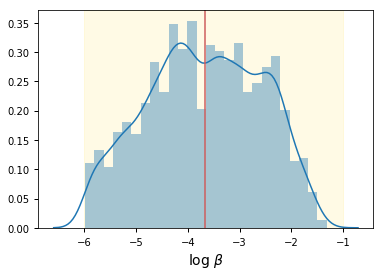

In [53]:
pmed, _, _, samples = dsampler.get_params(return_sample=True)
sns.distplot(samples[:,2])
plt.axvline(pmed[2], color='indianred')
plt.axvspan(-1, -6, color='gold',alpha=0.1,zorder=0)
plt.xlabel(r'log $\beta$')

In [73]:
10**(-3.77+2.06)

0.019498445997580455

## On Stage : Read and Stack all GCs

In [15]:
from jas1101finalproject.data import load_summary_table
summary = load_summary_table()

In [27]:
summary[summary['nstar']>2000]

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.015,5.8134967962492246,"1.3768803520135557,0.14529010919422547,-4.281715927103217"
NGC_288,13.1885,-26.582,8.9,-44.8,0.1,3.3,12.0,4.267,-5.636,0.054,0.053,0.018,2555.2,6.05,0.082,0.245,0.014,7.069072428543932,"7.7492974589059225,1.8159404374775876,-3.9825556142919"
NGC_362,15.8094,-70.848,8.6,223.3,0.3,8.8,12.0,6.73,-2.535,0.053,0.052,-0.004,1741.3,7.8,0.149,0.246,0.06,7.191601003948982,"2.714722157251669,0.7686700041638925,-8.124003325554805"
NGC_2808,138.012,-64.863,9.6,103.9,0.3,15.0,15.0,1.005,0.274,0.051,0.051,-0.006,1837.6,8.43,0.186,0.226,0.006,1.0416818132232126,"-3.0310622191397636,2.728031403769567,-8.690828872078345"
NGC_3201,154.403,-46.412,4.9,494.3,0.1,4.3,20.0,8.324,-1.991,0.044,0.044,0.001,7021.1,12.5,0.19,0.278,0.005,8.558799974295463,"-3.046820677500275,1.459595726639243,-3.549149767751881"
NGC_4372,186.439,-72.659,5.8,75.6,0.3,4.7,15.0,-6.378,3.358,0.05,0.05,0.001,2189.9,7.79,0.175,0.216,0.015,7.207985016632596,"-1.7178312698669347,-0.19386974276312463,-5.53637699683722"
NGC_4590_M_68,189.866,-26.744,10.3,-93.0,0.2,3.8,12.0,-2.752,1.762,0.054,0.053,-0.027,1479.1,6.73,0.083,0.246,0.05,3.2677435639902956,"-9.062138466800592,-1.5760555394290947,-4.635050738143855"
NGC_4833,194.891,-70.876,6.6,202.0,0.4,4.6,12.0,-8.361,-0.949,0.055,0.054,0.006,1861.3,7.08,0.177,0.201,0.009,8.414684902003165,"-2.089634324861634,-0.5556572400997536,-6.235757646019029"


In [77]:
gc_names = [fname.split('.')[0] for fname in os.listdir(os.path.join('../jas1101finalproject/data/', 'gcs')) if fname.endswith('ecsv')]

GCs = [GlobularCluster.from_name(name)
       for name in gc_names if summary[summary['Name']==name]['nstar']>2000]

In [78]:
len(GCs)

20

In [85]:
r_all = np.concatenate([gc.r for gc in GCs])
pm_all = np.concatenate([gc.pm - gc.pm.mean() for gc in GCs])
pm_e_all = np.concatenate([gc.pm_e for gc in GCs])
print(len(r_all))

good_all = pm_e_all < 2
print(good_all.sum())

128212
96913


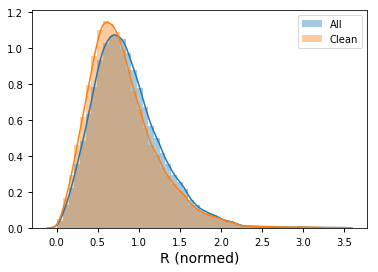

In [86]:
sns.distplot(r_all, label="All")
sns.distplot(r_all[good_all], label="Clean")

plt.xlabel("R (normed)")
plt.legend()

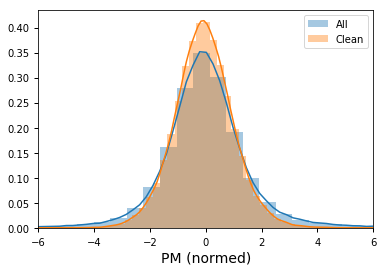

In [87]:
sns.distplot(pm_all[abs(pm_all)<15], label="All")
sns.distplot(pm_all[good_all], label="Clean")

plt.xlim(-6,6)
plt.xlabel("PM (normed)")
plt.legend()

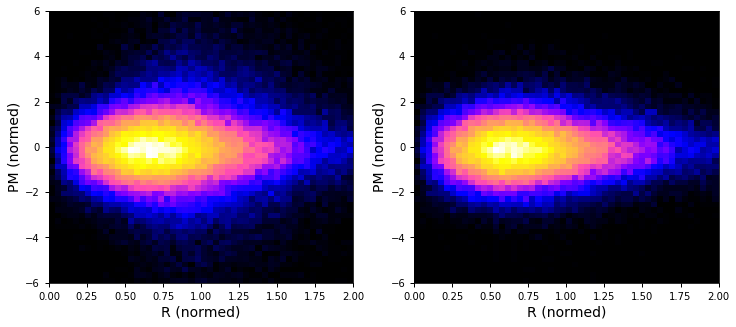

In [88]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
H, xb, yb, _ = ax1.hist2d(r_all, pm_all, bins=50, range=[[0,2],[-6,6]], norm=AsinhNorm(), cmap="gnuplot2")
H, xb, yb, _ = ax2.hist2d(r_all[good_all], pm_all[good_all], bins=50, range=[[0,2],[-6,6]], norm=AsinhNorm(), cmap="gnuplot2")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

Text(0, 0.5, '$\\sigma_r$ (normed)')

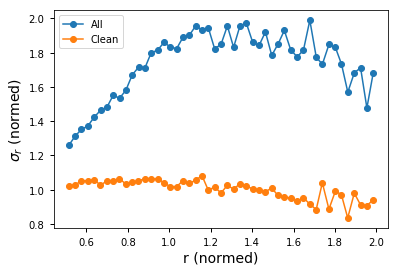

In [89]:
bins=np.linspace(0.5, 2, 50)

r_rbin, z_rbin, z_bins = profile_binning(r_all, pm_all, bins=bins, plot=False)
plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-', label="All")

r_rbin, z_rbin, z_bins = profile_binning(r_all[good_all], pm_all[good_all], bins=bins, plot=False)
plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-', label="Clean")

plt.legend()
plt.xlabel("r (normed)")
plt.ylabel("$\sigma_r$ (normed)")

In [91]:
kind = 'scale-outlier'
prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=25, mu_ol_max=25)
loglike = set_likelihood(r_all[good_all], pm_all[good_all], y_err=pm_e_all[good_all], kind=kind)

In [93]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=200, maxbatch=2)